# Double-bracket Iteration Scheduling Strategies

This notebook presents the different strategies for scheduling the step durations for the double-bracket iteration algorithm and their resepctive accuracies.

Import the dependencies

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *
from qibo.models.dbi.utils_strategies import *

## Canonical
Set up the basic test case with the transverse field ising model hamiltonian and the canonical bracket as the generator.

In [2]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi.off_diagonal_norm)

[Qibo 0.2.8|INFO|2024-05-29 08:09:34]: Using numpy backend on /CPU:0


Initial off diagonal norm 37.94733192202055


We first run a sweep of step duration to map the off-diagonal norm in this range.

In [3]:
# generate data for plotting sigma decrease of the first step
s_space = np.linspace(1e-5, 0.6, 100)
off_diagonal_norm_diff = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)

The default scheduling strategy is grid search: `DoubleBracketScheduling.
grid_serach`. This strategy specifies a list of step durations to test one by one and finds the one that maximizes the cost function (off-digonal norm of Hamiltonian)

In [4]:
# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, n=5)
print('polynomial_approximation step:', step_poly)
step_sa = dbi.choose_step(scheduling=DoubleBracketScheduling.simulated_annealing)
print('simulated_annealing step:', step_sa)

grid_search step: 0.030312727272727272
100%|██████████| 100/100 [00:00<00:00, 147.00trial/s, best loss: 28.83054565827672]
hyperopt_search step: 0.02847179092987961
polynomial_approximation step: 0.032960905003724034
simulated_annealing step: 0.026973122528658938


The minimum for cost function in the tested range is: 0.030312727272727272


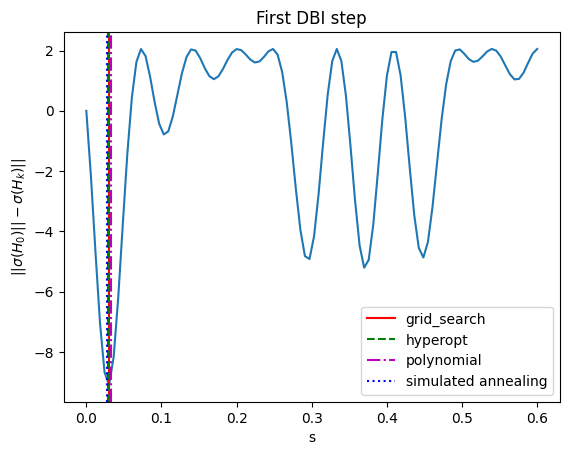

In [5]:
# Plot the results
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.axvline(x=step_sa, color='b', linestyle=':',label='simulated annealing')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

## Specified diagonal operator

While for the cannonical case, all the scheduling methods are accurate, it is important to realize that the global minimum of the loss function is not always so obvious. It is thus necessary to show whether the 3 converges to an agreeable step duration using different iteration generators, such as the Pauli 'ZZ..Z' operator and 'ZZ..I' operator.

In [6]:
# Generate the digaonal operators
Z_str = "Z"*nqubits
ZI_str = "Z"*(nqubits-1)+"I"
Z_op = SymbolicHamiltonian(str_to_symbolic(Z_str)).dense.matrix
ZI_op = SymbolicHamiltonian(str_to_symbolic(ZI_str)).dense.matrix
op_dict = {Z_str:Z_op, ZI_str: ZI_op}

[Qibo 0.2.8|WARNING|2024-05-29 08:09:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:09:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [7]:
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator)
d_str = ZI_str
d = op_dict[d_str]
# generate data for plotting sigma decrease of the first step
s_space = np.linspace(1e-5, 0.6, 100)
off_diagonal_norm_diff = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)

In [8]:
# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search, step_max=0.6, d=d)
grid_min = dbi.loss(step=step_grid, d=d)-dbi.off_diagonal_norm
print('grid_search step:', step_grid, 'loss', grid_min)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt, d=d, max_evals=100, step_max=0.6)
hyperopt_min = dbi.loss(step=step_hyperopt, d=d)-dbi.off_diagonal_norm
print('hyperopt_search step:', step_hyperopt, 'loss', hyperopt_min)
# polynomial expansion
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=5)
poly_min = dbi.loss(step=step_poly, d=d)-dbi.off_diagonal_norm
print('polynomial_approximation step:', step_poly, 'loss', poly_min)
# simulated annealing
step_sa = dbi.choose_step(scheduling=DoubleBracketScheduling.simulated_annealing, d=d)
sa_min = dbi.loss(step=step_sa, d=d)-dbi.off_diagonal_norm
print('simulated_annealing step:', step_sa, 'loss', sa_min)

grid_search step: 0.30303525252525254 loss -6.165348149025746
100%|██████████| 100/100 [00:01<00:00, 94.55trial/s, best loss: 31.779832293339304]
hyperopt_search step: 0.5652071095886648 loss -6.167499628681249
polynomial_approximation step: 0.04033688534030588 loss -6.149780650249905
simulated_annealing step: 0.48340531582403534 loss -6.145940509974928


The minimum for cost function in the tested range is: 0.30303525252525254


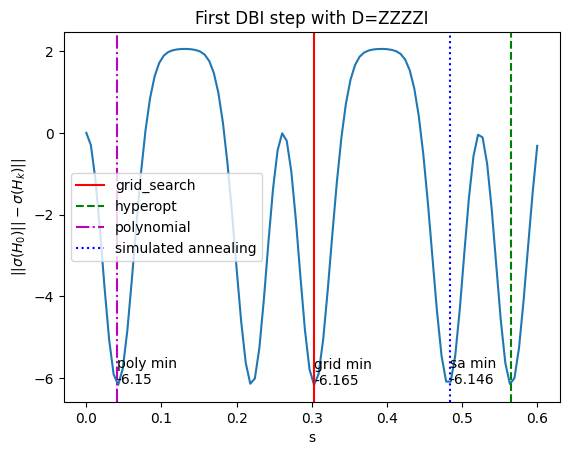

In [9]:
# Plot the results
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.text(x=step_grid, y=grid_min, s=f'grid min \n{round(grid_min,3)}')
plt.text(x=step_poly, y=poly_min, s=f'poly min \n{round(poly_min,3)}')
plt.text(x=step_sa, y=sa_min, s=f'sa min \n{round(sa_min,3)}')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.axvline(x=step_sa, color='b', linestyle=':',label='simulated annealing')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title(f'First DBI step with D={d_str}')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

We see that there are two similar "minimal point" at 0.03 and 0.22, with the latter being the absolute minimum by an insignificant advantage. However, for practical reasons, we prefer taking the first close-minimum calculated by polynomial approximation. Hence, we can use the polynomial approximation to restrict the search area and obtain better results. For example, we define a search range of 0.1 around the polynomial step.

## Use polynomial expansion as an restriction for hyperopt/grid range

In [10]:
search_range = 0.1
if step_poly < search_range/2:
    step_min = 0
    step_max = search_range
else:
    step_min = step_poly - search_range/2
    step_max = step_poly + search_range/2
# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search, step_min=step_min, step_max=step_max, d=d)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt, step_min=step_min, step_max=step_max, max_evals=100, d=d,)
print('hyperopt_search step:', step_hyperopt)

grid_search step: 0.04141414141414142
100%|██████████| 100/100 [00:00<00:00, 281.90trial/s, best loss: 31.780151135879148]
hyperopt_search step: 0.04197021755491067


The minimum for cost function in the tested range is: 0.04141414141414142


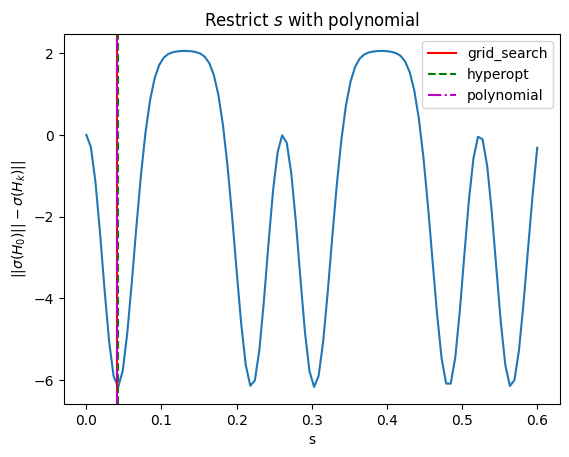

In [11]:
# Plot the results
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title(r'Restrict $s$ with polynomial')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

Hence, we see that the strategy is indeed effective for finding the first minimum of the loss funciton for both the Z operator and the ZI operator.

## Compare in Pauli-Z strategy

In [12]:
from qibo.quantum_info import random_hermitian
from qibo.hamiltonians import Hamiltonian

In [14]:
# Hamiltonian
set_backend("numpy")
nqubits = 4
h0 = random_hermitian(2**nqubits)

# initialize class
dbi = DoubleBracketIteration(deepcopy(Hamiltonian(nqubits=nqubits, matrix=h0)),mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi.off_diagonal_norm)

[Qibo 0.2.8|INFO|2024-05-29 08:10:04]: Using numpy backend on /CPU:0


Initial off diagonal norm 15.531689516799505


In [15]:
generate_local_Z = generate_Z_operators(nqubits)
Z_ops = list(generate_local_Z.values())
Z_names = list(generate_local_Z.keys())

[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-05-29 08:10:04]: Calculating the dens

In [16]:
NSTEPS = 8
scheduling_list = [DoubleBracketScheduling.grid_search,
                   DoubleBracketScheduling.hyperopt,
                   DoubleBracketScheduling.polynomial_approximation,
                   DoubleBracketScheduling.simulated_annealing,]
scheduling_labels = ['grid search',
                     'hyperopt',
                     'polynomial',
                     'simulated_annealing']
Z_optimal_scheduling = []
s_scheduling = []
off_norm_scheduling =[]
for i,scheduling in enumerate(scheduling_list):
    # reinitialize
    dbi = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=deepcopy(h0)), mode=DoubleBracketGeneratorType.single_commutator)
    Z_optimal = []
    # add in initial values for plotting
    off_diagonal_norm_history = [dbi.off_diagonal_norm]
    steps = [0]
    print(f'----------Scheduling {scheduling_labels[i]}----------')
    for _ in range(NSTEPS):
        dbi, idx, step, flip_sign = select_best_dbr_generator(dbi, Z_ops, scheduling=scheduling, compare_canonical=False)
        off_diagonal_norm_history.append(dbi.off_diagonal_norm)
        steps.append(steps[-1]+step)
        if flip_sign < 0:
            Z_optimal.append('-' + Z_names[idx])
        else:
            Z_optimal.append(Z_names[idx])
        print(f"New optimized step at iteration {_+1}/{NSTEPS}: {step} with operator {Z_optimal[-1]}, loss {dbi.off_diagonal_norm}")
    Z_optimal_scheduling.append(Z_optimal)
    s_scheduling.append(steps)
    off_norm_scheduling.append(off_diagonal_norm_history)

----------Scheduling grid search----------


/home/andreapasquale/qibo/src/qibo/models/dbi/utils_strategies.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  flip_list[i] = cs_angle_sgn(dbi_eval, d)


New optimized step at iteration 1/8: 0.1010190909090909 with operator IZZI, loss 12.32289315516495
New optimized step at iteration 2/8: 0.07071636363636363 with operator IZZI, loss 9.744596203115039
New optimized step at iteration 3/8: 0.06061545454545455 with operator IZZI, loss 8.666514218620271
New optimized step at iteration 4/8: 0.12122090909090909 with operator -ZIZZ, loss 7.525650014624014
New optimized step at iteration 5/8: 0.06061545454545455 with operator IZZI, loss 6.756888942369091
New optimized step at iteration 6/8: 0.12122090909090909 with operator IIZZ, loss 5.828802952436445
New optimized step at iteration 7/8: 0.08081727272727272 with operator -ZIZZ, loss 5.265860734824745
New optimized step at iteration 8/8: 0.08081727272727272 with operator IZZI, loss 4.799097209077483
----------Scheduling hyperopt----------
 70%|██████▉   | 348/500 [00:04<00:02, 70.17trial/s, best loss: 13.308835963869189] 


KeyboardInterrupt: 

In [ ]:
plt.figure()
for i, scheduling in enumerate(scheduling_labels):
    plt.plot(s_scheduling[i], off_norm_scheduling[i], '-o', label=scheduling)
plt.xlabel("Step durations")
plt.ylabel("Norm off-diagonal restriction")
plt.title("Compare Variational Pauli-Z using different scheduling strategies")
plt.legend()

## When polynomial approximation has no solution

In some cases, the prescribed taylor expansion order `n` may not be sufficient to produce a meaningful step duration (real positive). In these cases, we rely on a backup scheduling method in `choose_step`.

In [ ]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
dbi.scheduling = DoubleBracketScheduling.polynomial_approximation
print("Initial off diagonal norm", dbi.off_diagonal_norm)

For demonstration purposes, we let `n=1` which is a linear fit to the loss function. This results in no valid solutions and function `polynomial_step` returns `None`.

In [ ]:
for n in range (5):
    step = polynomial_step(dbi, n=n)
    print(n, step)
print(dbi.choose_step(n=1))